<h3 style="color: green;">Solution of the Poisson Equation Using Physics-Informed Neural Networks (PINN)</h3>


The goal of PINNs is to approximate the solution of a system of one or more possibly nonlinear differential equations by explicitly encoding the formulation of the differential equation into a neural network. In particular, we consider the Poisson equation
\begin{equation}
\nabla^{2}u(x,y)=\frac{1}{4}\sum_{k=1}^{4}(-1)^{k+1}2k\sin(k\pi x)\sin(k\pi y).
\end{equation}
in a unit square domain $[0,1]\times[0,1]$ with homogeneous Dirichlet boundary conditions.

In [14]:
import deepxde as dde 
from deepxde.backend import tf
import numpy as np 

Define the equation domain

In [15]:
geom = dde.geometry.Rectangle([0, 0], [1, 1])

Define the PDE

In [16]:
def pde(x, u):
    #summation = sum([((-1)**(i+1)) * (2*i) * tf.sin(i*np.pi*x) * tf.sin(i*np.pi*y) 
    #                 for i in range(1, 5)])
    summation =  2 * tf.sin(np.pi*x[:, 0:1]) * tf.sin(np.pi*x[:, 1:]) - \
                        4 * tf.sin(2*np.pi*x[:, 0:1]) * tf.sin(2*np.pi*x[:, 1:]) + \
                        6 * tf.sin(3*np.pi*x[:, 0:1]) * tf.sin(3*np.pi*x[:, 1:]) - \
                        8 * tf.sin(4*np.pi*x[:, 0:1]) * tf.sin(4*np.pi*x[:, 1:])
    d2u_dx2 = dde.grad.hessian(u, x, i=0, j=0)
    d2u_dy2 = dde.grad.hessian(u, x, i=1, j=1)
    return d2u_dx2 + d2u_dx2 - (1/4)*summation 

We impose the initial and boundary conditions.

In [18]:
def boundary(_, on_boundary):
    return on_boundary
bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary)

Define the PDE problem. The parameter _num_domain_ is the amount of collocation points used to discretized the inner domain.

In [19]:
data = dde.data.PDE(geom, pde, bc, num_domain=1500, num_boundary=120, num_test=1500)


Create the neural network. Here, we use a fully connected neural network of depth 5 (i.e., 3 hidden layers) and width 20. Besides, we choose tanh as activation function and Glorot uniform as initializer :

<center><img src="red.png" alt="Descripción de la imagen" style="width: 50%; height: auto;"></center>

In [20]:
layer_size = [2] + [20] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

Now, we have the PDE problem and the network. We build a Model.

In [21]:
model = dde.Model(data, net)

Choose the optimizer and learning rate. We first train the model for 5000 iterations with Adam optimizer and then we train the model again using L-BFGS-B.

In [22]:
model.compile("adam", lr=1e-2)
losshistory, train_state = model.train(iterations=10000)
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

Compiling model...
Building feed-forward neural network...
'build' took 0.101693 s



/home/danny/local/miniconda3/envs/mlearning/lib/python3.11/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.543347 s

Training model...

0         [2.03e+00, 7.76e-02]    [2.25e+00, 7.76e-02]    []  
1000      [5.79e-03, 4.43e-04]    [4.49e-03, 4.43e-04]    []  
2000      [1.53e-03, 8.04e-05]    [1.25e-03, 8.04e-05]    []  
3000      [1.06e-03, 5.50e-05]    [9.52e-04, 5.50e-05]    []  
4000      [1.24e-03, 3.54e-05]    [1.15e-03, 3.54e-05]    []  
5000      [1.00e-03, 2.44e-05]    [8.01e-04, 2.44e-05]    []  
6000      [7.25e-04, 2.17e-05]    [6.21e-04, 2.17e-05]    []  
7000      [4.67e-03, 1.93e-05]    [4.02e-03, 1.93e-05]    []  
8000      [4.34e-04, 1.49e-05]    [3.58e-04, 1.49e-05]    []  
9000      [6.53e-04, 1.53e-05]    [5.97e-04, 1.53e-05]    []  
10000     [1.54e-03, 1.60e-05]    [1.54e-03, 1.60e-05]    []  

Best model at step 8000:
  train loss: 4.49e-04
  test loss: 3.73e-04
  test metric: []

'train' took 434.205231 s

Compiling model...
'compile' took 0.421291 s

Training model...

Step      Train loss              Test loss               Test metric
10000    

Save the training data

Saving loss history to /home/danny/repos/dmikan/ComputationalPhysics2023/2023-06-08-pinns-deepxde/loss.dat ...
Saving training data to /home/danny/repos/dmikan/ComputationalPhysics2023/2023-06-08-pinns-deepxde/train.dat ...
Saving test data to /home/danny/repos/dmikan/ComputationalPhysics2023/2023-06-08-pinns-deepxde/test.dat ...


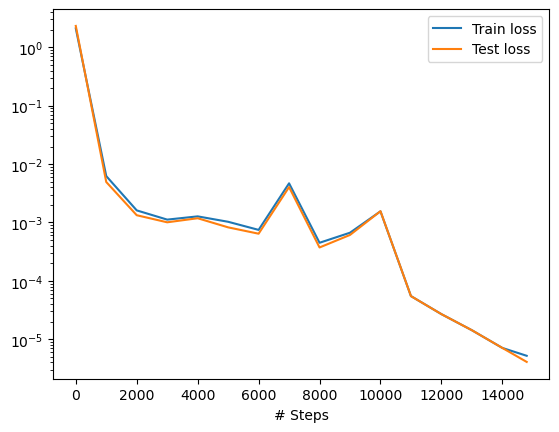

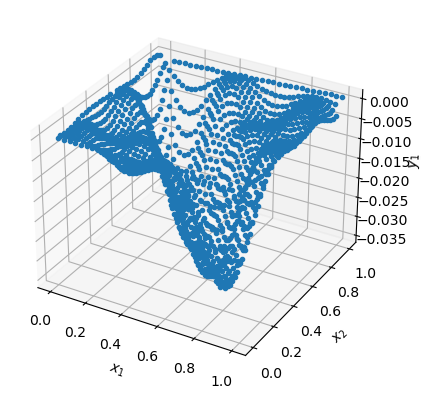

In [31]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Plot the solution on the squared domain

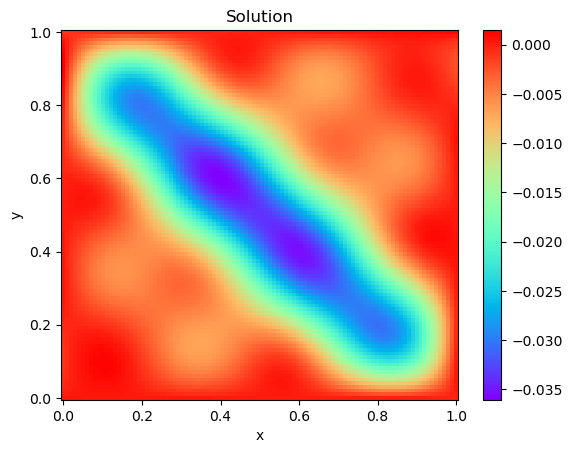

In [203]:
x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
X, Y = np.meshgrid(x,y)
domain = np.vstack((np.ravel(X),np.ravel(Y))).T
solution = model.predict(domain).reshape((len(x), len(y)))

import matplotlib.pyplot as plt
plt.pcolormesh(X, Y, solution, cmap='rainbow')
plt.colorbar()
plt.title('Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('poisson-version1.pdf')

Import the training data and plot the data

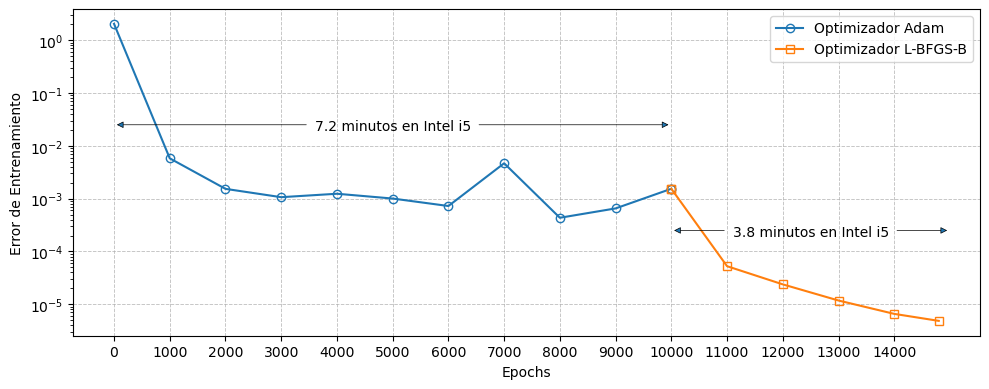

In [141]:
import numpy as np
import matplotlib.pyplot as plt

# Cargar los datos de loss.dat
data = np.loadtxt('loss.dat', skiprows=1)  # Saltar la primera fila que contiene los encabezados

# Extraer las columnas de datos
step = data[:, 0]
loss_train = data[:, 1]

# Crear la gráfica con un tamaño personalizado
fig, ax = plt.subplots(figsize=(10, 4))  # Especifica el ancho y alto de la figura en pulgadas

# Dividir la línea continua en dos colores
ax.semilogy(step[step <= 10000], loss_train[step <= 10000],'o-', markerfacecolor='none', label='Optimizador Adam')
ax.semilogy(step[step >= 10000], loss_train[step >= 10000],'s-', markerfacecolor='none', label='Optimizador L-BFGS-B')

# Graficar loss_train en escala logarítmica en y
#ax.semilogy(step, loss_train, 'o-', label='Loss Train')

# Personalizar la gráfica
ax.set_xlabel('Epochs')
ax.set_ylabel('Error de Entrenamiento')
ax.legend()

# Establecer etiquetas personalizadas en el eje x
xticks = np.arange(0, max(step) + 1, 1000)
ax.set_xticks(xticks)


# Establecer la escala logarítmica en el eje y
ax.set_yscale('log')

# Agregar la cuadrícula
ax.grid(True, linestyle='dotted', linewidth=0.5, dashes=(5, 2))

# Agregar el tiempo de cómputo sobre la línea de la gráfica
# Tiempo de cómputo en segundos
ax.text(3600, 0.02, '7.2 minutos en Intel i5', color='black')
ax.text(11100, 0.0002, '3.8 minutos en Intel i5', color='black')

# Agregar el segmento con flechas
ax.annotate('', xy=(0, 0.025), xytext=(3500, 0.025),
            arrowprops=dict(arrowstyle='-|>', lw=0.5),
            annotation_clip=False)

ax.annotate('', xy=(6500, 0.025), xytext=(10000, 0.025),
            arrowprops=dict(arrowstyle='<|-', lw=0.5),
            annotation_clip=False)

# Agregar el segmento con flechas
ax.annotate('', xy=(10000, 0.00025), xytext=(11000, 0.00025),
            arrowprops=dict(arrowstyle='-|>', lw=0.5),
            annotation_clip=False)

ax.annotate('', xy=(14000, 0.00025), xytext=(15000, 0.00025),
            arrowprops=dict(arrowstyle='<|-', lw=0.5),
            annotation_clip=False)

# Mostrar la gráfica
plt.tight_layout()  # Ajustar automáticamente el espacio entre elementos de la gráfica
plt.savefig('training-error.pdf')
plt.show()


Solve the equation using finite differences in order to compare the methods

Tiempo de ejecución:  3.24664306640625 segundos


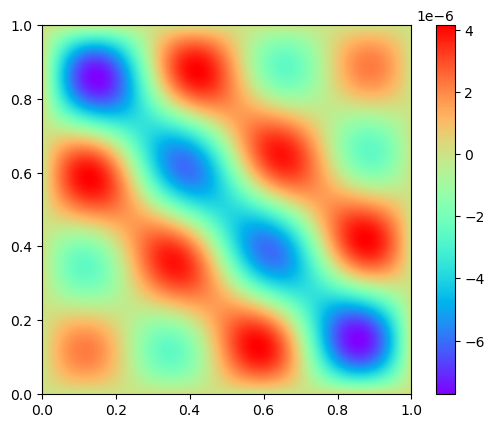

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Definir la malla en el dominio x
x = np.linspace(0, 1, 512)
x_len = len(x)
dx = x[1] - x[0]

# Definir la malla en el dominio y
y = np.linspace(0, 1, 512)
y_len = len(y)
dy = y[1] - y[0]

# Criterio de convergencia
tol = 0.000001

# Inicializar matriz u
u = np.zeros((x_len, y_len))

# Condiciones de contorno
u[0, :] = 0
u[-1, :] = 0
u[:, 0] = 0
u[:, -1] = 0

# Iteraciones para resolver la ecuación
error = 1
start_time = time.time()
while error > tol:
    for i in range(1, x_len - 1):
        for j in range(1, y_len - 1):
            u_p = u[i, j]
            
            # Método iterativo para resolver la ecuación de Laplace
            u[i, j] = 0.25 * (u[i+1, j] + u[i-1, j] + u[i, j+1] + u[i, j-1] -
                        dx**2 * 0.25 * (2 * np.sin(np.pi * x[i]) * np.sin(np.pi * y[j])
                                - 4 * np.sin(2 * np.pi * x[i]) * np.sin(2 * np.pi * y[j])
                                + 6 * np.sin(3 * np.pi * x[i]) * np.sin(3 * np.pi * y[j])
                                - 8 * np.sin(4 * np.pi * x[i]) * np.sin(4 * np.pi * y[j])))

    # Comprobar la convergencia
    error = np.max(np.abs(u[i, j] - u_p))

end_time = time.time()
execution_time = end_time - start_time
print("Tiempo de ejecución: ", execution_time, "segundos")
    
# Graficar la solución
plt.imshow(u, origin='lower', extent=[0, 1, 0, 1], cmap='rainbow')
plt.colorbar()
plt.show()

Plot and compare the solutions

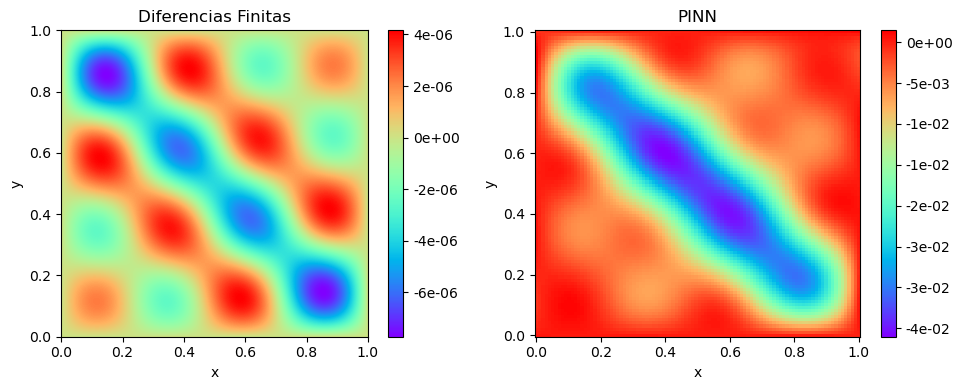

In [215]:
# Crear una figura con dos subtramas
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Trazar la primera gráfica en la subtrama izquierda
im1 = axs[0].imshow(u, origin='lower', extent=[0, 1, 0, 1], cmap='rainbow')
axs[0].set_title('Diferencias Finitas')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
fig.colorbar(im1, ax=axs[0], format='%.0e')

# Generar datos para la segunda gráfica
x2 = np.linspace(0, 1, 100)
y2 = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x2, y2)
domain = np.vstack((np.ravel(X), np.ravel(Y))).T
solution = model.predict(domain).reshape((len(x), len(y)))

# Trazar la segunda gráfica en la subtrama derecha
im2 = axs[1].pcolormesh(X, Y, solution, cmap='rainbow')
axs[1].set_title('PINN')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
fig.colorbar(im2, ax=axs[1], format='%.0e')   

plt.tight_layout()
plt.savefig('fin-dif-pinn.pdf')
plt.show()